# Getting Started with LangChain 🦜️🔗 + Vertex AI PaLM API on BigQuery

Self Lik: go/workbench-bq-langchain-vertex-genai

| | |
|----------|-------------|
| Author(s)   | Sagar Kewalramani (skewalramani@) |



Credits : 
References from Rajesh Thallam (rthallam@) & Nikhil Rana (nikhilrana@) work


## Objective
This notebook provides an introductory understanding of [Langchain]((https://langchain.com/)) components and use cases of LangChain with BigQuery & Vertex PaLM APIs.

- ✅ Introduce LangChain components
- ✅ Showcase LangChain + BigQuery +  Vertex PaLM API - Text
- ✅ Question/Answering from BigQuery Table (retrieval based)

---

**References:**

- Adapted from [LangChain Cookbook](https://github.com/gkamradt/langchain-tutorials) from [Greg Kamradt](https://twitter.com/GregKamradt)
- [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)
- [LangChain Python Documentation](https://python.langchain.com/en/latest/)


In [ ]:
!python --version

### **What is LangChain?**
> LangChain is a framework for developing applications powered by language models.

**TL;DR** LangChain makes the complicated parts of working & building with AI models easier. It helps do this in two ways:

1. **Integration** - Bring external data, such as your files, other applications, and api data, to your LLMs
2. **Agents** - Allow your LLMs to interact with it's environment via decision making. Use LLMs to help decide which action to take next


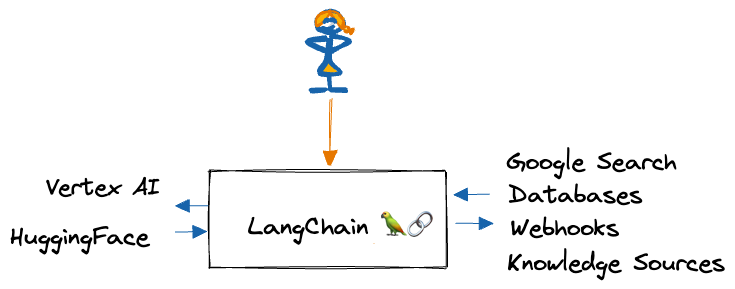


Often times, you may want to augment LLMs with external data sources and make decisions based on outputs of LLMs. Here are a few - like calling SQL after we asked LLM to generate a SQL based on text, or call a webhook/API based on response, or synthesize outputs from multiple LLM calls, or call LLMs in a specific order. It may look trivial to plumb these API calls together and orchestrate them but it gets boring to write glue code again e.g. for every different data connector or LLM. That’s where LangChain comes in. Its modular implementation and common patterns combining these components make it easier to build complex applications based on LLMs.

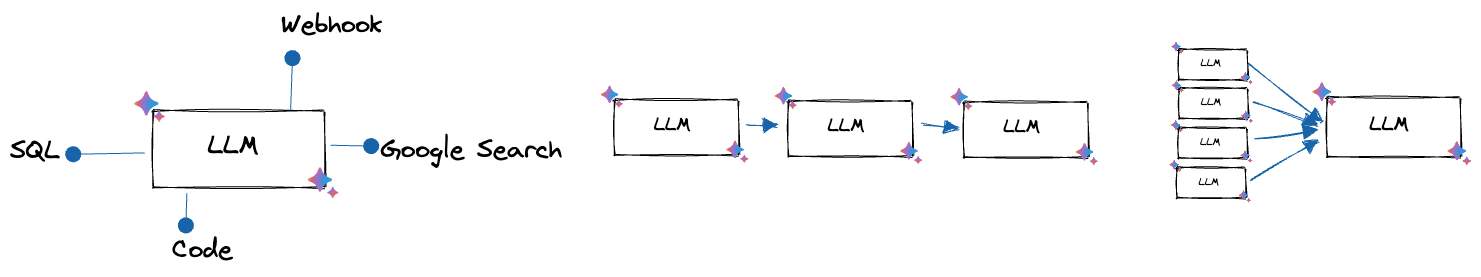

### **Why LangChain?**
1. **Components** - LangChain makes it easy to swap out abstractions and components necessary to work with language models.

2. **Customized Chains** - LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together.

3. **Speed 🚢** - This team ships insanely fast. You'll be up to date with the latest LLM features.

4. **Community 👥** - Wonderful discord and community support, meet ups, hackathons, etc.

Though LLMs can be straightforward (text-in, text-out) you'll quickly run into friction points that LangChain helps with once you develop more complicated applications.

*Note: This notebook does not cover all aspects of LangChain. It's contents have been curated to get you to building & impact as quick as possible. For more, please check out [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)*

# Install Vertex AI LLM SDK

In [ ]:
PATH = get_ipython().run_line_magic("env", "PATH")
%env PATH={PATH}:/home/jupyter/.local/bin

In [ ]:

! pip install --user --quiet google-cloud-aiplatform==1.25.0

# Install pandas
! pip install --user --quiet pandas

# Install HuggingFace Datasets
! pip install --user --quiet datasets

# Install Python client for Google Search API
! pip install --user --quiet google-api-python-client

# PDF loader
! pip install --user --quiet pypdf

# Install similarity search library
# TO-DO: Replace with vertex AI Matching Engine
! pip install --user --quiet faiss-cpu

# Install LangChain & SQL Alchemy
### LangChain is an open source frameowrk that allows AI developers to combine LLM like PaLM with external sources of computation and data
### SQLAlchemy is an open-source SQL toolkit and object-relational mapper for the Python programming language released under the MIT License.
### Gradio is an open-source Python library that is used to build machine learning and data science demos and web applications.

In [ ]:
# Install Python Libraries
!pip install --user chromadb --quiet
!pip install --user langchain==0.0.157 --quiet
!pip install --user google-cloud-core --quiet
!pip install --user gradio --quiet

# Below libraries are required to build a SQL engine for BigQuery
!pip install --user SQLAlchemy==1.4.48 --quiet
!pip install --user sqlalchemy-bigquery --quiet

In [ ]:
!pip freeze | grep SQLAlchemy


In [ ]:
# Load necessary libraries
import os
if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---

#### ⚠️ Do not forget to "RESTART RUNTIME" 

---

In [ ]:
PROJECT_ID = "<UPDATE YOUR PROJECT ID>"  # @param {type:"string"} ## Update this with your project id
LOCATION = "us-central1" # @param {type:"string"} ## Continue with us-central1

---

#### ⚠️ Do not forget to update the PROJECT_ID to your project

---

# LangChain Components

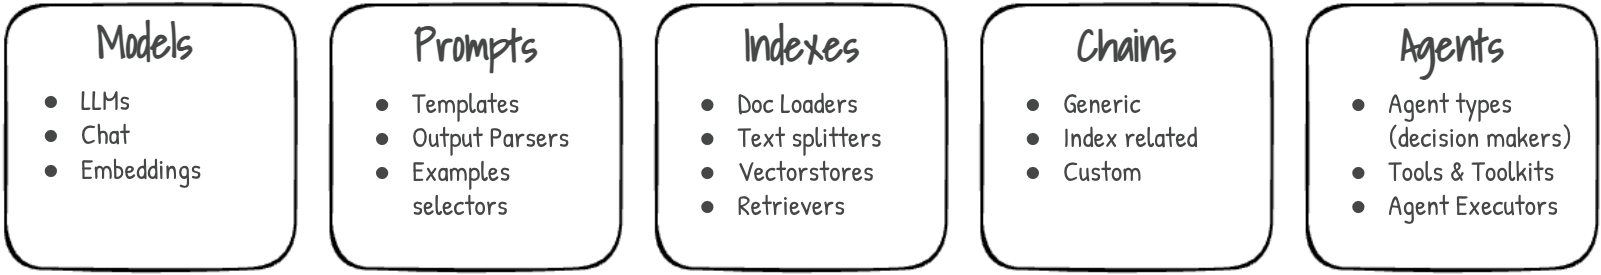

In [ ]:
import langchain
print(f"LangChain version: {langchain.__version__}")

from google.cloud import aiplatform
print(f"Vertex AI SDK version: {aiplatform.__version__}")

# Initialize Vertex AI SDK
import vertexai
vertexai.init(project=PROJECT_ID, location=LOCATION)

# Vertex AI LLM wrapper for using with Langchain
# Eventually this wrapper will be replaced by official Langchain + Vertex AI integration

In [ ]:


import time
from typing import Any, Mapping, List, Dict, Optional, Tuple, Union
from dataclasses import dataclass, field

from pydantic import BaseModel, Extra, root_validator

from langchain.llms.base import LLM
from langchain.embeddings.base import Embeddings
from langchain.chat_models.base import BaseChatModel
from langchain.llms.utils import enforce_stop_tokens
from langchain.schema import Generation, LLMResult
from langchain.schema import AIMessage, BaseMessage, ChatGeneration, ChatResult, HumanMessage, SystemMessage

from vertexai.preview.language_models import TextGenerationResponse, ChatSession


def rate_limit(max_per_minute):
  period = 60 / max_per_minute
  print('Waiting')
  while True:
    before = time.time()
    yield
    after = time.time()
    elapsed = after - before
    sleep_time = max(0, period - elapsed)
    if sleep_time > 0:
      print('.', end='')
      time.sleep(sleep_time)


class _VertexCommon(BaseModel):
    """Wrapper around Vertex AI large language models.

    To use, you should have the
    ``google.cloud.aiplatform.private_preview.language_models`` python package
    installed.
    """
    client: Any = None #: :meta private:
    model_name: str = "text-bison@001"
    """Model name to use."""

    temperature: float = 0.2
    """What sampling temperature to use."""

    top_p: int = 0.8
    """Total probability mass of tokens to consider at each step."""

    top_k: int = 40
    """The number of highest probability tokens to keep for top-k filtering."""

    max_output_tokens: int = 200
    """The maximum number of tokens to generate in the completion."""

    @property
    def _default_params(self) -> Mapping[str, Any]:
        """Get the default parameters for calling Vertex AI API."""
        return {
            "temperature": self.temperature,
            "top_p": self.top_p,
            "top_k": self.top_k,
            "max_output_tokens": self.max_output_tokens
        }

    def _predict(self, prompt: str, stop: Optional[List[str]]) -> str:
        res = self.client.predict(prompt, **self._default_params)
        return self._enforce_stop_words(res.text, stop)

    def _enforce_stop_words(self, text: str, stop: Optional[List[str]]) -> str:
        if stop:
            return enforce_stop_tokens(text, stop)
        return text

    @property
    def _llm_type(self) -> str:
        """Return type of llm."""
        return "vertex_ai"

class VertexLLM(_VertexCommon, LLM):
    model_name: str = "text-bison@001"

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import TextGenerationModel
        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["client"] = TextGenerationModel.from_pretrained(values["model_name"])
        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        """Call out to Vertex AI's create endpoint.

        Args:
            prompt: The prompt to pass into the model.

        Returns:
            The string generated by the model.
        """
        return self._predict(prompt, stop)


@dataclass
class _MessagePair:
    """InputOutputTextPair represents a pair of input and output texts."""

    question: HumanMessage
    answer: AIMessage


@dataclass
class _ChatHistory:
    """InputOutputTextPair represents a pair of input and output texts."""

    history: List[_MessagePair] = field(default_factory=list)
    system_message: Optional[SystemMessage] = None


def _parse_chat_history(history: List[BaseMessage]) -> _ChatHistory:
    """Parses a sequence of messages into history.

    A sequency should be either (SystemMessage, HumanMessage, AIMessage,
    HumanMessage, AIMessage, ...) or (HumanMessage, AIMessage, HumanMessage,
    AIMessage, ...).
    """
    if not history:
        return _ChatHistory()
    first_message = history[0]
    system_message = first_message if isinstance(first_message, SystemMessage) else None
    chat_history = _ChatHistory(system_message=system_message)
    messages_left = history[1:] if system_message else history
    # if len(messages_left) % 2 != 0:
    #     raise ValueError(
    #         f"Amount of messages in history should be even, got {len(messages_left)}!"
    #     )
    for question, answer in zip(messages_left[::2], messages_left[1::2]):
        if not isinstance(question, HumanMessage) or not isinstance(answer, AIMessage):
            raise ValueError(
                "A human message should follow a bot one, "
                f"got {question.type}, {answer.type}."
            )
        chat_history.history.append(_MessagePair(question=question, answer=answer))
    return chat_history


class _VertexChatCommon(_VertexCommon):
    """Wrapper around Vertex AI Chat large language models.

    To use, you should have the
    ``vertexai.preview.language_models`` python package
    installed.
    """
    model_name: str = "chat-bison@001"
    """Model name to use."""

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import ChatModel
        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["client"] = ChatModel.from_pretrained(values["model_name"])
        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    def _response_to_chat_results(
        self, response: TextGenerationResponse, stop: Optional[List[str]]
    ) -> ChatResult:
        text = self._enforce_stop_words(response.text, stop)
        return ChatResult(generations=[ChatGeneration(message=AIMessage(content=text))])


class VertexChat(_VertexChatCommon, BaseChatModel):
    """Wrapper around Vertex AI large language models.

    To use, you should have the
    ``vertexai.preview.language_models`` python package
    installed.
    """

    model_name: str = "chat-bison@001"
    chat: Any = None  #: :meta private:

    def send_message(
        self, message: Union[HumanMessage, str], stop: Optional[List[str]] = None
    ) -> ChatResult:
        text = message.content if isinstance(message, BaseMessage) else message
        response = self.chat.send_message(text)
        text = self._enforce_stop_words(response.text, stop)
        return ChatResult(generations=[ChatGeneration(message=AIMessage(content=text))])

    def _generate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        if not messages:
            raise ValueError(
                "You should provide at least one message to start the chat!"
            )
        question = messages[-1]
        if not isinstance(question, HumanMessage):
            raise ValueError(
                f"Last message in the list should be from human, got {question.type}."
            )
        self.start_chat(messages[:-1])
        return self.send_message(question)

    def start_chat(self, messages: List[BaseMessage]) -> None:
        """Starts a chat."""
        history = _parse_chat_history(messages)
        context = history.system_message.content if history.system_message else None
        self.chat = self.client.start_chat(context=context, **self._default_params)
        for pair in history.history:
            self.chat._history.append((pair.question.content, pair.answer.content))

    def clear_chat(self) -> None:
        self.chat = None

    @property
    def history(self) -> List[BaseMessage]:
        """Chat history."""
        history: List[BaseMessage] = []
        if self.chat:
            for question, answer in self.chat._history:
                history.append(HumanMessage(content=question))
                history.append(AIMessage(content=answer))
        return history

    async def _agenerate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        raise NotImplementedError(
            """Vertex AI doesn't support async requests at the moment."""
        )

class VertexMultiTurnChat(_VertexChatCommon, BaseChatModel):
    """Wrapper around Vertex AI large language models."""

    model_name: str = "chat-bison@001"
    chat: Optional[ChatSession] = None

    def clear_chat(self) -> None:
        self.chat = None

    def start_chat(self, message: Optional[SystemMessage] = None) -> None:
        if self.chat:
            raise ValueError("Chat has already been started. Please, clear it first.")
        if message and not isinstance(message, SystemMessage):
            raise ValueError("Context should be a system message")
        context = message.content if message else None
        self.chat = self.client.start_chat(context=context, **self._default_params)

    @property
    def history(self) -> List[Tuple[str]]:
        """Chat history."""
        if self.chat:
            return self.chat._history
        return []

    def _generate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        if len(messages) != 1:
            raise ValueError(
                "You should send exactly one message to the chat each turn."
            )
        if not self.chat:
            raise ValueError("You should start_chat first!")
        response = self.chat.send_message(messages[0].content)
        return self._response_to_chat_results(response, stop=stop)

    async def _agenerate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        raise NotImplementedError(
            """Vertex AI doesn't support async requests at the moment."""
        )

class VertexEmbeddings(Embeddings, BaseModel):
    """Wrapper around Vertex AI large language models embeddings API.

    To use, you should have the
    ``google.cloud.aiplatform.private_preview.language_models`` python package
    installed.
    """
    model_name: str = "textembedding-gecko@001"
    """Model name to use."""

    model: Any
    requests_per_minute: int = 15


    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import TextEmbeddingModel

        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["model"] = TextEmbeddingModel

        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    class Config:
        """Configuration for this pydantic object."""

        extra = Extra.forbid

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
      """Call Vertex LLM embedding endpoint for embedding docs
      Args:
          texts: The list of texts to embed.
      Returns:
          List of embeddings, one for each text.
      """
      self.model = self.model.from_pretrained(self.model_name)

      limiter = rate_limit(self.requests_per_minute)
      results = []
      docs = list(texts)

      while docs:
        # Working in batches of 2 because the API apparently won't let
        # us send more than 2 documents per request to get embeddings.
        head, docs = docs[:2], docs[2:]
        # print(f'Sending embedding request for: {head!r}')
        chunk = self.model.get_embeddings(head)
        results.extend(chunk)
        next(limiter)

      return [r.values for r in results]

    def embed_query(self, text: str) -> List[float]:
      """Call Vertex LLM embedding endpoint for embedding query text.
      Args:
        text: The text to embed.
      Returns:
        Embedding for the text.
      """
      single_result = self.embed_documents([text])
      return single_result[0]

In [ ]:
REQUESTS_PER_MINUTE = 100

llm = VertexLLM(
    model_name='text-bison@001',
    max_output_tokens=256,
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

chat = VertexChat()

mchat = VertexMultiTurnChat(max_output_tokens=1024)

embedding = VertexEmbeddings(requests_per_minute=REQUESTS_PER_MINUTE)

# Create your input DataSet

### Replace your project name in the following code

In [ ]:
from google.cloud import bigquery
from google.cloud.bigquery import Client
client = Client(project=PROJECT_ID)
dataset_id = "iowa_liquor_sales"

In [ ]:
query = """
CREATE `{PROJECT_ID}.{dataset_id}`
OPTIONS(
  location="us"
  )
""".format(
    PROJECT_ID=PROJECT_ID, dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

In [ ]:
query = """
create or replace table `{PROJECT_ID}.{dataset_id}.sales`
as
select invoice_and_item_number,
date,
store_number,
store_name,
address,
city,
zip_code,
county_number,
county,
category,
category_name,
vendor_number,
vendor_name,
item_number,
item_description,
pack,
bottle_volume_ml,
state_bottle_cost,
state_bottle_retail,
bottles_sold,
sale_dollars,
volume_sold_liters,
volume_sold_gallons
from `bigquery-public-data.iowa_liquor_sales.sales`
""".format(
    PROJECT_ID=PROJECT_ID, dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

In [ ]:
# @title Specify Project details and location of the BQ table

project_id = PROJECT_ID  # @param {type:"string"}
location = LOCATION  # @param {type:"string"}
dataset_id = 'iowa_liquor_sales' # @param {type:"string"}
table_name = 'sales' # @param {type:"string"}


In [ ]:
from sqlalchemy import *
from sqlalchemy.engine import create_engine
from sqlalchemy.schema import *
import pandas as pd

In [ ]:
table_uri = f"bigquery://{project_id}/{dataset_id}"
engine = create_engine(f"bigquery://{project_id}/{dataset_id}")

In [ ]:
query=f"""SELECT * FROM `{project_id}.{dataset_id}.{table_name}`"""
engine.execute(query).first()

In [ ]:
from langchain import SQLDatabase, SQLDatabaseChain
from langchain.prompts.prompt import PromptTemplate

def bq_qna(question):
  #create SQLDatabase instance from BQ engine
  db = SQLDatabase(engine=engine,metadata=MetaData(bind=engine),include_tables=[table_name])
  # db = SQLDatabase(engine=engine,metadata=MetaData(bind=engine),include_tables=['bigquery-public-data.iowa_liquor_sales.sales'])

  #create SQL DB Chain with the initialized LLM and above SQLDB instance
  db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True, return_intermediate_steps=True)

  #Define prompt for BigQuery SQL
  _googlesql_prompt = """You are a BigQuery SQL expert. Given an input question, first create a syntactically correct BigQuery query to run, then look at the results of the query and return the answer to the input question.
  Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per BigQuery SQL. You can order the results to return the most informative data in the database.
  Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
  Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
  Use the following format:
  Question: "Question here"
  SQLQuery: "SQL Query to run"
  SQLResult: "Result of the SQLQuery"
  Answer: "Final answer here"
  Only use the following tables:
  {table_info}

  If someone asks for specific month, use ActivityDate between current month's start date and current month's end date

  Question: {input}"""

  BigQuerySQL_PROMPT = PromptTemplate(
      input_variables=["input", "table_info", "top_k"],
      template=_googlesql_prompt,
  )

  #passing question to the prompt template
  final_prompt = BigQuerySQL_PROMPT.format(input=question, table_info=table_name, top_k=10000)

  #pass final prompt to SQL Chain
  output = db_chain(final_prompt)


  return output['result'], output['intermediate_steps'][0]


In [ ]:
#Testing 1
bq_qna('Count total number of invoices')

In [ ]:
#Testing 2
bq_qna('what were the total sales for County DALLAS in 2022?')

In [ ]:
#Testing 3
# bq_qna('Identify the top stores along with their zipcode & city name in terms of Number of Sales')
bq_qna('Can you identify the stores with the highest number of sales? Please provide the store names along with their zip codes , dollar sales and city names.')



In [ ]:
#Testing 4
# bq_qna('Extract month from the date field and sum the monthly sales every month for "GLENLIVET 12YR"  in 2023? Show the results as month name[January]: sales for every month  in 2023')
bq_qna('Write an SQL query to extract the month from the date field, calculate the sum of monthly sales for "GLENLIVET 12YR" in 2023, and display the results as month name followed by sales for each month in 2023.')



In [ ]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown(
    """
    ## Ask BigQuery

    This demo is to showcase answering questions on a tabular data available in Big Query using Vertex PALM LLM & Langchain.

    Dataset: Public dataset on Iowa Liquor Sales

    Dataset dimensions: ~26 million rows and 24 columns



    ### Sample Inputs:
    1. Count total number of invoices
    2. Identify the top stores along with their zipcode & city name in terms of Number of Sales
    3. Write an SQL query to extract the month from the date field, calculate the sum of monthly sales for "GLENLIVET 12YR" in 2023, and display the results as month name followed by sales for each month in 2023.

    ### Enter a search query...

    """)
    with gr.Row():
      with gr.Column():
        input_text = gr.Textbox(label="Question", placeholder="Count total number of invoices")

    with gr.Row():
      generate = gr.Button("Ask BigQuery")

    with gr.Row():
      label2 = gr.Textbox(label="Output")
    with gr.Row():
      label3 = gr.Textbox(label="SQL query generated by LLM")

    generate.click(bq_qna,input_text, [label2, label3])
demo.launch(share=True, debug=False)